# Explore how to work with a Mixture Density Network

In [17]:
import sys
sys.path.append("..")
from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
import pprint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from behavior_cloning.mdn import MDN, mdn_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Specify and load the experiment
experiment = "behavior_cloning"
run = "mdn_00" 
exp = Config().get_experiment(experiment, run)
pprint.pprint(exp)

***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\behavior_cloning\mdn_00_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: behavior_cloning/mdn_00 successfully loaded
Experiment:
    control_size: 6
    data_dir: c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-experiments\behavior_cloning\mdn_00
    epochs: 10
    exp_run_sys_indep_file: C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\behavior_cloning\mdn_00.yaml
    experiment_name: behavior_cloning
    hidden_size: 128
    input_dim: 1
    loss: MSELoss
    num_gaussians: 5
    optimizer: Adam
    optimizer_lr: 0.001
    output_dim: 1
    run_name: mdn_00
    sequence_length: 10
    subrun_name: null
    test_data:
    - - random-both-cameras
      - '2025_03_08__14_23_19'
      - dev2
    - - random-both-cameras
      - '2025_03_08__14_24_52'
      - dev2
    training_data:
 

### Generate synthetic training data
The synthetic training data is a noisy sine wave, defined on the interval [-]

In [19]:
# --- Example Usage ---
# 1. Generate some synthetic data (e.g., a noisy sine wave)
np.random.seed(42)
num_samples = 1000
X = np.random.rand(num_samples, 1) * 10 - 5 # Input in range [-5, 5]
# X = np.random.uniform(-5, 5, num_samples) 
# ^ this creates just a vector, not the right shape
y_true = np.sin(X) * 2 + np.random.randn(num_samples, 1) * 0.5 # Noisy sine wave

# Introduce some multi-modality for demonstration
# y_true[X[:, 0] > 2] += 2 # Shift part of the sine wave up
# y_true[X[:, 0] < -2] -= 2 # Shift part of the sine wave down
y_true[0:num_samples//3] = -2.0 * y_true[0:num_samples//3] # Shift part of the sine wave up

X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y_true)

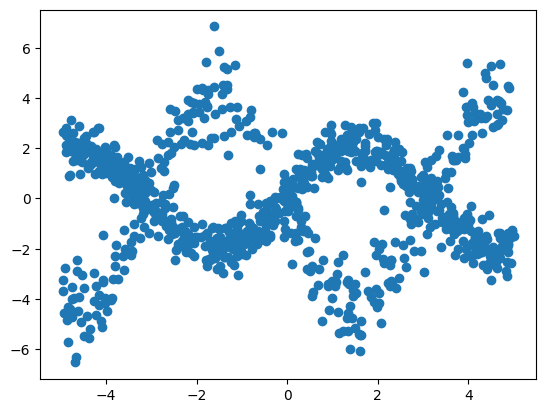

In [20]:
# Visualize the data
x = X_tensor.numpy()
y = y_tensor.numpy()
# Create figure and axes
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.show()

### Training the MDN

In [21]:

input_dim = 1
output_dim = 1
num_gaussians = 5 # Number of Gaussian components

model = MDN(exp)
model_path = pathlib.Path(exp.data_dir(), "mdn.pth")
if model_path.exists():
    model.load_state_dict(torch.load(model_path))
else:
    # model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    num_epochs = 200 # was 2000, buty it was not improving after 100
    batch_size = 64

    # X_tensor = X_tensor.to(device)
    # y_tensor = y_tensor.to(device)

    print("Starting training...")
    for epoch in range(num_epochs):
        # Mini-batch training
        permutation = torch.randperm(num_samples)
        for i in range(0, num_samples, batch_size):
            indices = permutation[i:i+batch_size]
            batch_X, batch_y = X_tensor[indices], y_tensor[indices]
            # batch_X = batch_X.to(device)
            # batch_y = batch_y.to(device)
            optimizer.zero_grad()
            mu, sigma, pi = model(batch_X)
            loss = mdn_loss(batch_y, mu, sigma, pi)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


    torch.save(model.state_dict(), model_path)
    print("Training finished.")


Starting training...
Epoch [2/200], Loss: 2.2122
Epoch [4/200], Loss: 1.6915
Epoch [6/200], Loss: 1.7258
Epoch [8/200], Loss: 1.5100
Epoch [10/200], Loss: 1.6446
Epoch [12/200], Loss: 1.5911
Epoch [14/200], Loss: 1.5279
Epoch [16/200], Loss: 1.7871
Epoch [18/200], Loss: 1.6915
Epoch [20/200], Loss: 1.3195
Epoch [22/200], Loss: 1.7766
Epoch [24/200], Loss: 1.6831
Epoch [26/200], Loss: 1.5422
Epoch [28/200], Loss: 1.8055
Epoch [30/200], Loss: 1.6717
Epoch [32/200], Loss: 1.6708
Epoch [34/200], Loss: 1.6134
Epoch [36/200], Loss: 1.6760
Epoch [38/200], Loss: 1.5515
Epoch [40/200], Loss: 1.5354
Epoch [42/200], Loss: 1.6547
Epoch [44/200], Loss: 1.6563
Epoch [46/200], Loss: 1.6013
Epoch [48/200], Loss: 1.5352
Epoch [50/200], Loss: 1.6770
Epoch [52/200], Loss: 1.4935
Epoch [54/200], Loss: 1.4418
Epoch [56/200], Loss: 1.6410
Epoch [58/200], Loss: 1.2478
Epoch [60/200], Loss: 1.5875
Epoch [62/200], Loss: 1.7743
Epoch [64/200], Loss: 1.5717
Epoch [66/200], Loss: 1.5768
Epoch [68/200], Loss: 1.13

### Evaluating the trained model

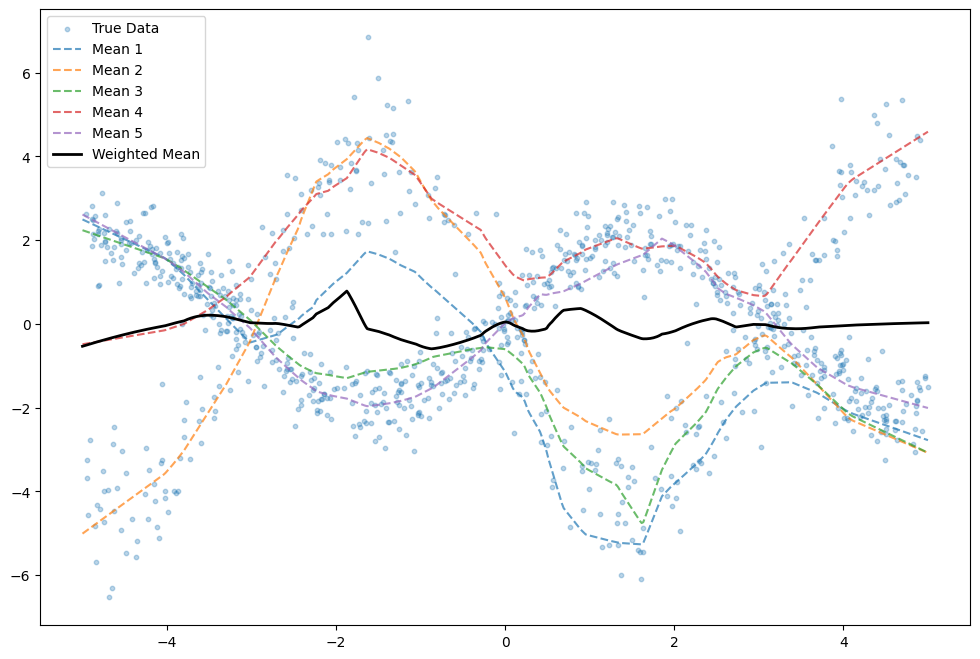

In [22]:

# 2. Make predictions and visualize
# Create a range of input values for prediction
X_test = torch.linspace(-5, 5, 500).unsqueeze(1)
with torch.no_grad():
    mu_pred, sigma_pred, pi_pred = model(X_test)

# Visualize the results
plt.figure(figsize=(12, 8))
plt.scatter(X, y_true, s=10, alpha=0.3, label='True Data')

# Plot the means
for i in range(num_gaussians):
    plt.plot(X_test.numpy(), mu_pred[:, 0, i].numpy(), '--', alpha=0.7,
                label=f'Mean {i+1}')

# Plot the predicted distribution's mean (weighted average of component means)
# This is often not very informative for multimodal distributions, but good for understanding
weighted_mean = torch.sum(pi_pred * mu_pred, dim=-1)
plt.plot(X_test.numpy(), weighted_mean[:, 0].numpy(), 'k-', linewidth=2, label='Weighted Mean')

plt.legend()


(500, 2000)


C:\Users\lboloni\AppData\Local\Temp\ipykernel_86968\1343339588.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


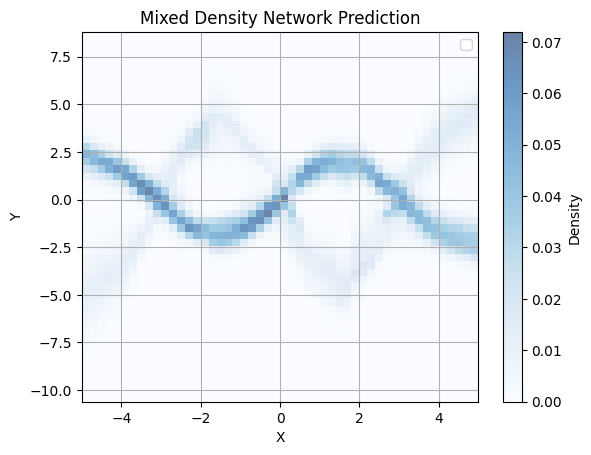

In [23]:

# Plot the predictive distribution (e.g., by sampling or showing density contours)
# A common way is to draw samples from the predicted mixture model
num_samples_from_mdn = 2000

y_samples = model.sample(num_samples_from_mdn, mu_pred, sigma_pred, pi_pred)
print(y_samples.shape)

# retval = torch.cat(y_samples).numpy()            
# flatten out all the examples 


X_test_repeated = X_test.repeat_interleave(num_samples_from_mdn, dim=0).numpy()
plt.hist2d(X_test_repeated.flatten(), y_samples.flatten(), bins=(50, 50), cmap='Blues', alpha=0.6, density=True)
plt.colorbar(label='Density')
plt.title('Mixed Density Network Prediction')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()



For X = 0.5:
  Gaussian 1:
    Mean (mu): -3.1309
    Std Dev (sigma): 0.2822
    Mixing Coeff (pi): 0.0717
  Gaussian 2:
    Mean (mu): -1.5155
    Std Dev (sigma): 0.2948
    Mixing Coeff (pi): 0.0993
  Gaussian 3:
    Mean (mu): -2.0539
    Std Dev (sigma): 0.6696
    Mixing Coeff (pi): 0.1903
  Gaussian 4:
    Mean (mu): 1.1298
    Std Dev (sigma): 0.4066
    Mixing Coeff (pi): 0.5710
  Gaussian 5:
    Mean (mu): 0.7006
    Std Dev (sigma): 0.2063
    Mixing Coeff (pi): 0.0676


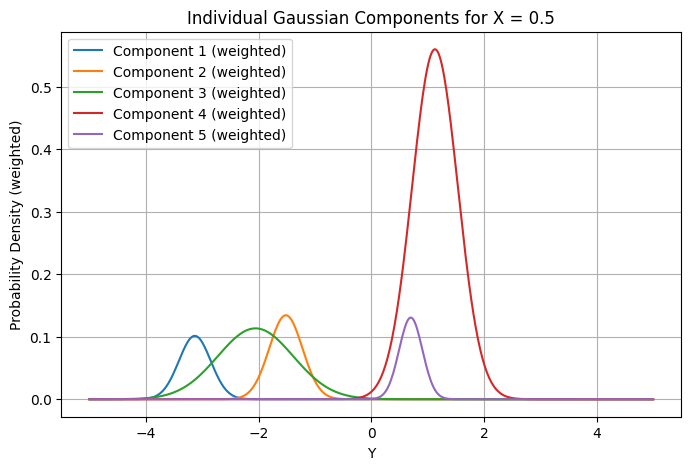

In [24]:

# You can also visualize individual Gaussian components for a specific input X
# For example, let's pick a specific X value (e.g., X = 0)
x_example = torch.tensor([[0.5]])
with torch.no_grad():
    mu_ex, sigma_ex, pi_ex = model(x_example)

print(f"\nFor X = {x_example.item()}:")
for i in range(num_gaussians):
    print(f"  Gaussian {i+1}:")
    print(f"    Mean (mu): {mu_ex[0, 0, i].item():.4f}")
    print(f"    Std Dev (sigma): {sigma_ex[0, 0, i].item():.4f}")
    print(f"    Mixing Coeff (pi): {pi_ex[0, 0, i].item():.4f}")

mu_ex_np = mu_ex.numpy()
sigma_ex_np = sigma_ex.numpy()
pi_ex_np = pi_ex.numpy()

# Plot the individual Gaussians for the example
plt.figure(figsize=(8, 5))
y_vals = np.linspace(-5, 5, 500)
for i in range(num_gaussians):
    pdf = (1 / (sigma_ex_np[0, 0, i] * np.sqrt(2 * np.pi))) * \
          np.exp(-0.5 * ((y_vals - mu_ex_np[0, 0, i]) / sigma_ex_np[0, 0, i])**2)
    plt.plot(y_vals, pdf * pi_ex_np[0, 0, i], label=f'Component {i+1} (weighted)')

plt.title(f'Individual Gaussian Components for X = {x_example.item()}')
plt.xlabel('Y')
plt.ylabel('Probability Density (weighted)')
plt.legend()
plt.grid(True)
plt.show()